In [4]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [1]:
import json
path_to_res = '/work/data/results/7_6_2023_tp_graph_5re.txt'
results = json.load(open(path_to_res))

In [33]:
save_figs = '/work/files/'

In [5]:
import torch
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h, rel_types))
        h = F.relu(self.conv2(g, h, rel_types))
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
            #return F.sigmoid( self.classify(hg))
#model = Classifier(113, 20, 1)
best_model_path = '/work/data/models7_6/best_f1_model_287.pt'
model = torch.load(best_model_path)
model.eval()
model

Classifier(
  (conv1): RelGraphConv(
    (linear_r): TypedLinear(in_size=113, out_size=32, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (linear_r): TypedLinear(in_size=32, out_size=32, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (classify): Linear(in_features=32, out_features=2, bias=True)
)

In [7]:
from dgl_classifier. trainer import predict2samples
train_file = '/work/data/splits/splits_0.050/train.json'
val_file = '/work/data/splits/splits_0.050/val.json'
test_file = '/work/data/splits/splits_0.050/test.json'
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=10, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/May2/pred_clust.json')

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


In [9]:
from dgl_classifier.post import *
JB_train_rt, oracle_rt_train = get_runtime(train_data)
J_train_rt, B_train_rt = get_runtimes_wo_pred(train_data)

JB_val_rt, oracle_rt_val = get_runtime(val_data)
J_val_rt, B_val_rt = get_runtimes_wo_pred(val_data)

JB_test_rt, oracle_rt_test = get_runtime(test_data)
J_test_rt, B_test_rt = get_runtimes_wo_pred(test_data)

In [10]:
print('Train\n','\tWith Predictions ',round(np.mean(JB_train_rt),3),', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter',round(np.mean(B_train_rt),3),', Oracle',round(np.mean(oracle_rt_train),3))
print('Validation\n','\tWith Predictions ',round(np.mean(JB_val_rt),3),', Jena: ', round(np.mean(J_val_rt),3), ', Bloom Filter',round(np.mean(B_val_rt),3), ', Oracle',round(np.mean(oracle_rt_val),3))
print('Test\n','\tWith Predictions ',round(np.mean(JB_test_rt),3),', Jena: ', round(np.mean(J_test_rt),3), ', Bloom Filter',round(np.mean(B_test_rt),3),', Oracle',round(np.mean(oracle_rt_test),3))

Train
 	With Predictions  7.419 , Jena:  7.434 , Bloom Filter 8.161 , Oracle 7.407
Validation
 	With Predictions  8.624 , Jena:  8.627 , Bloom Filter 9.019 , Oracle 8.466
Test
 	With Predictions  4.183 , Jena:  4.189 , Bloom Filter 4.637 , Oracle 4.179


Relative Errors

In [16]:
def relative_improvements(JB_rt, J):
    return [(( j-jb)/j)*100 for jb, j in zip(JB_rt, J)] 
train_re_im = relative_improvements(JB_train_rt,J_train_rt)
val_re_im = relative_improvements(JB_val_rt,J_val_rt)
test_re_im = relative_improvements(JB_test_rt,J_test_rt)

In [13]:

for idx,x in enumerate(val_re_im):
    if x > 9.5:
        print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Improvement  17.005  JenaBloom RT  0.026  Jena RT  0.031 Absolute difference in MS 5.242
Relative Improvement  10.751  JenaBloom RT  0.192  Jena RT  0.215 Absolute difference in MS 23.152
Relative Improvement  42.866  JenaBloom RT  0.028  Jena RT  0.048 Absolute difference in MS 20.636
Relative Improvement  22.282  JenaBloom RT  0.007  Jena RT  0.01 Absolute difference in MS 2.127
Relative Improvement  26.28  JenaBloom RT  0.024  Jena RT  0.033 Absolute difference in MS 8.58
Relative Improvement  10.721  JenaBloom RT  0.005  Jena RT  0.006 Absolute difference in MS 0.641
Relative Improvement  11.749  JenaBloom RT  0.01  Jena RT  0.011 Absolute difference in MS 1.314
Relative Improvement  11.692  JenaBloom RT  0.07  Jena RT  0.08 Absolute difference in MS 9.322
Relative Improvement  10.121  JenaBloom RT  0.007  Jena RT  0.008 Absolute difference in MS 0.762
Relative Improvement  27.187  JenaBloom RT  0.226  Jena RT  0.31 Absolute difference in MS 84.343
Relative Improvement  11

In [17]:
def print_stat(re_s):
    print("Mean ", round(np.mean(re_s),3))
    print("STD ", round(np.std(re_s),3))
    print("Min ", round(np.min(re_s),3))
    print("25% ", round(np.quantile(re_s,q=0.25),3))
    print("50% ", round(np.quantile(re_s,q=0.5),3))
    print("75% ", round(np.quantile(re_s,q=0.75),3))
    print("Max ", round(np.max(re_s),3))

In [18]:
print_stat(train_re_im)

Mean  3.096
STD  9.235
Min  -34.161
25%  0.0
50%  0.0
75%  6.144
Max  74.439


In [19]:
print_stat(val_re_im)

Mean  3.218
STD  9.991
Min  -41.818
25%  0.0
50%  0.0
75%  6.604
Max  42.866


In [20]:
print_stat(test_re_im)

Mean  1.392
STD  8.871
Min  -46.525
25%  0.0
50%  0.0
75%  5.015
Max  23.677


Hoe many cases can we improve on our test dataset

In [21]:
(len([x for x in test_re_im if x > 0]) / len(test_re_im))*100

32.55813953488372

In [ ]:
round( np.mean(J_train_rt)- np.mean(JB_train_rt),3),', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter',round(np.mean(B_train_rt),3),', Oracle',round(np.mean(oracle_rt_train),3))

In [28]:
((np.mean(J_train_rt)- np.mean(JB_train_rt))/np.mean(J_train_rt))*100

0.21037709064211668

In [36]:
import matplotlib.pyplot as plt

def bxp_rel_impr(re, title, save=None):
    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    plt.boxplot(re)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png')
    plt.show()

<Figure size 640x480 with 0 Axes>

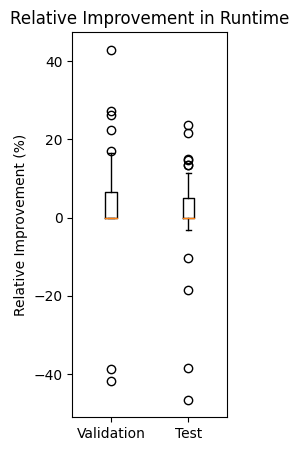

In [121]:
def bxp_rel_impr_w_both(re_val,re_test, title, save=None):
    plt.clf()
    #plt.figure()
    fig, ax = plt.subplots(figsize=(2,5))
    data = {'Validation': re_val, 'Test': re_test}
    ax.boxplot(data.values())
    ax.set_xticklabels(data.keys())
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png', bbox_inches='tight')
    plt.show()
bxp_rel_impr_w_both(val_re_im,test_re_im, 'Relative Improvement in Runtime', save='rel_impro_rt')

<Figure size 640x480 with 0 Axes>

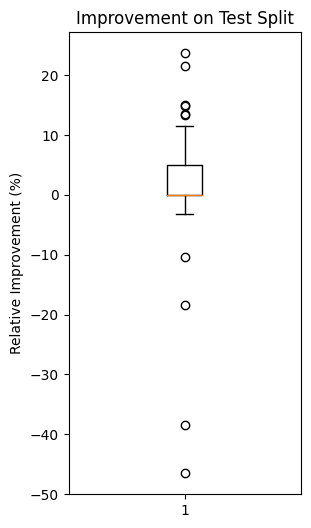

In [38]:
bxp_rel_impr(test_re_im, "Improvement on Test Split",save='test_re_impr_bxp')

<Figure size 640x480 with 0 Axes>

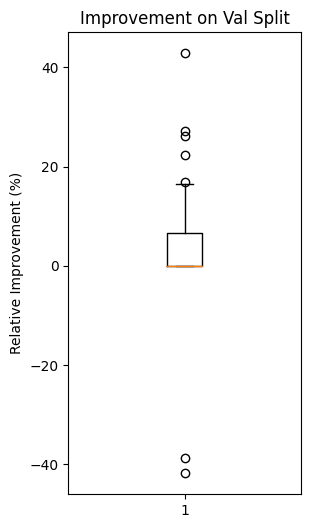

In [37]:
bxp_rel_impr(val_re_im, "Improvement on Val Split",save='val_re_impr_bxp')

In [124]:
for idx,x in enumerate(val_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Decline  -38.772  JenaBloom RT  0.086  Jena RT  0.062 Absolute difference in MS -23.976
Relative Decline  -41.818  JenaBloom RT  0.139  Jena RT  0.098 Absolute difference in MS -40.85


In [123]:
for idx,x in enumerate(test_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_test_rt[idx],3),' Jena RT ', round(J_test_rt[idx],3), 'Absolute difference in MS',round((J_test_rt[idx] -JB_test_rt[idx] )*1e3,3))

Relative Decline  -10.372  JenaBloom RT  0.013  Jena RT  0.012 Absolute difference in MS -1.245
Relative Decline  -3.107  JenaBloom RT  0.035  Jena RT  0.034 Absolute difference in MS -1.062
Relative Decline  -18.426  JenaBloom RT  0.003  Jena RT  0.003 Absolute difference in MS -0.514
Relative Decline  -46.525  JenaBloom RT  0.067  Jena RT  0.046 Absolute difference in MS -21.386
Relative Decline  -38.396  JenaBloom RT  0.085  Jena RT  0.061 Absolute difference in MS -23.533


# Runtime Statistics

In [42]:
def differences_in_MS(J_rt, JB_rt):
    return [(j-jb)*1e3 for j, jb in zip(J_rt, JB_rt)]
val_dif = differences_in_MS(J_val_rt, JB_val_rt)
test_dif = differences_in_MS(J_test_rt, JB_test_rt)
print(np.sum(val_dif), np.sum(test_dif))

261.6357780000002 508.8141750000006


In [50]:
import pandas as pd
pd.DataFrame(val_dif)

,0
0,0.000000
1,2.184073
2,0.000000
3,5.241712
4,23.151874
...,...
79,0.761667
80,20.135561
81,0.000000
82,0.000000


In [49]:
list(range(-50,100,10))

[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

0
(-45.0, -40.0]     1
(-25.0, -20.0]     1
(-0.1, 0.0]       50
(0.0, 5.0]        20
(5.0, 10.0]        5
(15.0, 20.0]       1
(20.0, 25.0]       4
(75.0, 80.0]       1
(80.0, 85.0]       1
Name: count, dtype: int64


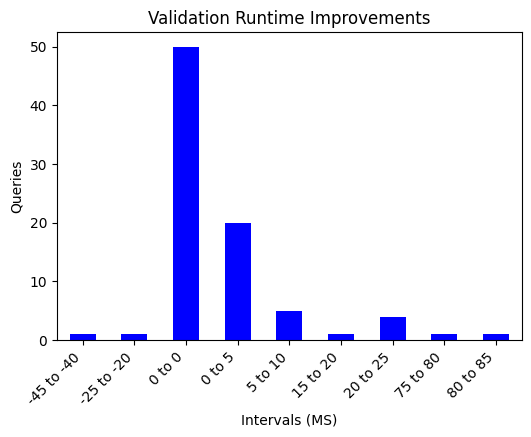

0
(-25.0, -20.0]     2
(-5.0, -0.1]       3
(-0.1, 0.0]       53
(0.0, 5.0]        18
(5.0, 10.0]        3
(10.0, 15.0]       3
(20.0, 25.0]       1
(25.0, 30.0]       1
(50.0, 55.0]       1
Name: count, dtype: int64


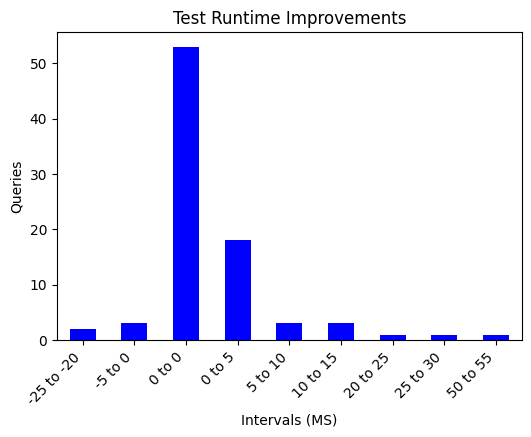

In [122]:
import pandas as pd
def difference_in_bar(diffs, title, save = None):
    s = pd.DataFrame(diffs)
    bins = list(range(-50,100,5))
    bins.append(-0.1)
    bins = sorted(bins)
    out = pd.cut(s[0], bins=bins, include_lowest=True)
    out = out.cat.remove_unused_categories()
    value_counts = out.value_counts(sort=False)
    print(value_counts)
    ys = [value_counts.iloc[x] for x in range(len(value_counts))]
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
    ax.set_xticklabels([f"{int(c.left)} to {int(c.right)}" for c in out.cat.categories],rotation = 45, ha="right")
    plt.title(title)
    plt.xlabel('Intervals (MS)')
    plt.ylabel('Queries')
    if save != None:
        plt.savefig(f'{save_figs}{save}.png', bbox_inches='tight')
    plt.show()
difference_in_bar(val_dif, 'Validation Runtime Improvements', save='no_improvements_val')
difference_in_bar(test_dif, 'Test Runtime Improvements', save='no_improvements_test')